In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [425]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [381]:
data = pd.read_csv('data/house_prices.csv')

In [382]:
df = data.copy()
df

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


### Visualize Distributions of columns and Look at what columns we have

In [383]:
df = df.drop(columns=['Unnamed: 0', 'Id'])

In [384]:
print(df.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object


In [385]:
def columns_with_null(df: pd.DataFrame) -> np.ndarray: 
    series = df.isnull().sum()
    series = series[series != 0]
    return series.index

def categorical_columns(df: pd.DataFrame) -> np.ndarray:
    return df.select_dtypes(exclude=['number']).columns.values

def numerical_columns(df: pd.DataFrame) -> np.ndarray:
    return df.select_dtypes(include=['number']).columns.values

def skewed_columns(df: pd.DataFrame) -> np.ndarray:
    num_cols = numerical_columns(df)
    series = df[num_cols].skew()
    return series[np.abs(series) > 1.5].index.values

def flag_sparse_col(df: pd.DataFrame, p=0.5) -> np.ndarray:
    N = df.shape[0]
    series = df.isnull().sum()
    series = series[series >= p * N]
    return series.index

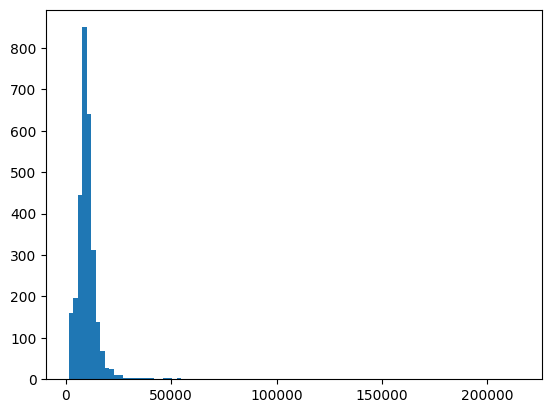

In [386]:
plt.hist(df['LotArea'], bins=100)
plt.show()

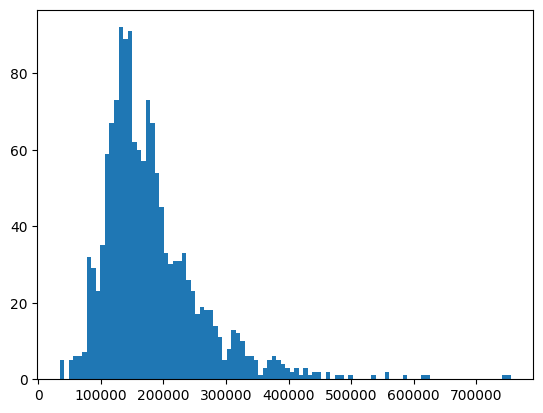

In [387]:
plt.hist(df['SalePrice'], bins=100)
plt.show()

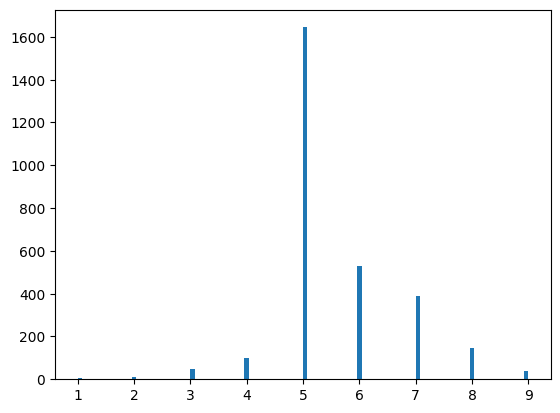

In [388]:
plt.hist(df['OverallCond'], bins=100)
plt.show()

In [389]:
df = df.drop(columns=flag_sparse_col(df))
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,NaN
2915,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,700,7,2006,WD,Normal,NaN


In [390]:
df = df.dropna(subset=['SalePrice'])
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000.0
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000.0
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500.0
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125.0


In [391]:
num_cols = numerical_columns(df)
cat_cols = categorical_columns(df)
skewed_columns = skewed_columns(df)

skewed_features = [feature for feature in skewed_columns if feature != 'SalePrice']
num_standard = num_cols[~np.isin(num_cols, skewed_columns)]

In [412]:
## setting up the transformer pipelines 

log_pipeline = Pipeline(
    steps = [
        ('impute', KNNImputer(n_neighbors=3)),
        ('log', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ]
)

num_pipeline = Pipeline(
    steps = [
        ('impute', KNNImputer(n_neighbors=3)),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps = [
        ('impute', SimpleImputer(strategy='constant', fill_value='missing')), 
        ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ]
)

In [413]:
## define the column transformer 

preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_pipeline, skewed_features),
        ('num_pipeline', num_pipeline, num_standard),
        ('cat_pipeline', cat_pipeline, cat_cols)
    ]
)

In [414]:
ridge_model = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge())
])

In [415]:
## hyperparameter values 
param_grid_ridge = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [416]:
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

opt_ridge = GridSearchCV(
    ridge_model,
    param_grid=param_grid_ridge,
    cv=kf,
    scoring='r2'
)

In [417]:
X, Y = df.drop(columns=['SalePrice']), df['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [418]:
opt_ridge.fit(X_train, Y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...l', Ridge())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__alpha': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displ

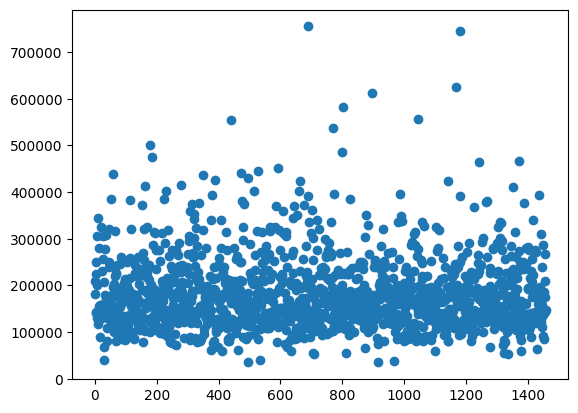

In [419]:
plt.scatter(df.index, df['SalePrice'])

In [422]:
Y_pred = opt_ridge.predict(X_test)

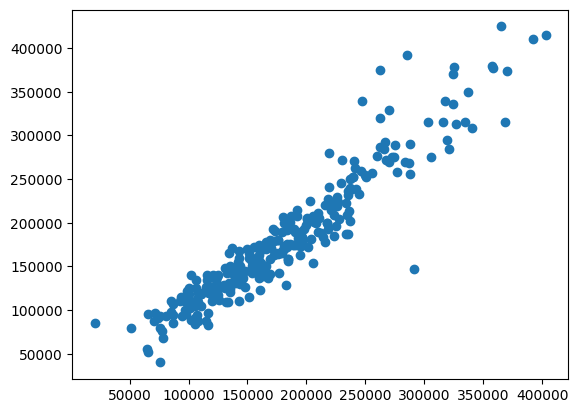

In [423]:
plt.scatter(Y_pred, Y_test)

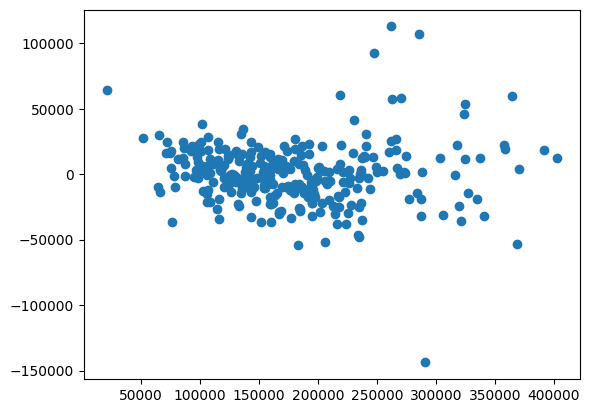

In [424]:
residuals = Y_test - Y_pred
plt.scatter(Y_pred, residuals)

In [426]:
print(f"MAE: {mean_absolute_error(Y_test, Y_pred)}")
print(f"RMSE: {root_mean_squared_error(Y_test, Y_pred)}")
print(f"R2 Score: {r2_score(Y_test, Y_pred)}")

MAE: 16578.40132855703
RMSE: 23840.32702418765
R2 Score: 0.8915399761253203
